In [1]:
# Imports here
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import models, datasets, transforms

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])
                                     ])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_set = datasets.ImageFolder(train_dir, transform = train_transform)
test_set = datasets.ImageFolder(test_dir, transform = test_transforms)
valid_set = datasets.ImageFolder(valid_dir, transform = valid_transforms)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=True)

In [6]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [7]:
# TODO: Build and train your network
model = models.vgg16(pretrained=True)
model;

In [8]:
device = torch.device('cuda')
for params in model.parameters() :
    params.requires_grad = False
    
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088,500)),
    ('relu1', nn.ReLU()),
    ('dropout', nn.Dropout(p = 0.2)),
    ('fc2', nn.Linear(500,102)),
    ('output', nn.LogSoftmax(dim=1))    
    
]))

model.classifier = classifier

In [9]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)

In [10]:
model.cuda();
def validation(model,criterion, testloader):
    testloss = 0
    accuracy = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)
        testloss += criterion(output,labels).item()

        ps = torch.exp(output)
        equality = (labels.data ==ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    return testloss, accuracy


In [11]:

import time
epochs = 3
print_every = 10
steps = 0
running_loss = 0

stp=[]
ts_loss = []
tr_loss = []
accu = []
#total_time = time.time()
for e in range(epochs):
    model.train()
    
    for images,labels in trainloader:
        steps += 1
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logits = model.forward(images)
        loss = criterion(logits, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            
            with torch.no_grad():
                testloss, accuracy = validation(model,criterion, testloader)
                
                
            print('Epochs {}/{} '.format(e+1, epochs),
                  'train loss {:.3f} '.format(running_loss/print_every),
                  'test loss {:.3f} '.format(testloss/len(testloader)),
                  'accuracy {:.3f} '.format(accuracy/len(testloader)))
            
            tr_loss.append(running_loss/print_every)     
            stp.append(steps)    
            ts_loss.append(testloss/len(testloader))
            accu.append(accuracy/len(testloader))
            
            running_loss = 0
            model.train()

#print("total_time {} minutes".format(time.time()-total_time())/60)            

Epochs 1/3  train loss 5.135  test loss 3.973  accuracy 0.194 
Epochs 1/3  train loss 3.919  test loss 3.425  accuracy 0.257 
Epochs 1/3  train loss 3.556  test loss 3.004  accuracy 0.352 
Epochs 1/3  train loss 3.408  test loss 2.501  accuracy 0.428 
Epochs 1/3  train loss 2.978  test loss 2.091  accuracy 0.505 
Epochs 1/3  train loss 2.512  test loss 1.892  accuracy 0.508 
Epochs 1/3  train loss 2.538  test loss 1.754  accuracy 0.556 
Epochs 1/3  train loss 2.311  test loss 1.534  accuracy 0.590 
Epochs 1/3  train loss 2.351  test loss 1.469  accuracy 0.620 
Epochs 1/3  train loss 2.032  test loss 1.371  accuracy 0.628 
Epochs 1/3  train loss 2.023  test loss 1.421  accuracy 0.615 
Epochs 1/3  train loss 1.899  test loss 1.243  accuracy 0.687 
Epochs 1/3  train loss 1.710  test loss 1.192  accuracy 0.690 
Epochs 1/3  train loss 1.676  test loss 1.143  accuracy 0.689 
Epochs 1/3  train loss 1.666  test loss 1.103  accuracy 0.707 
Epochs 1/3  train loss 1.609  test loss 1.066  accuracy

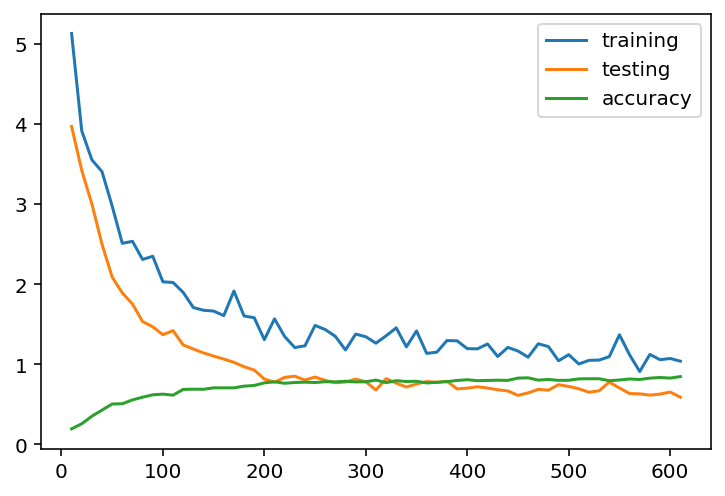

In [16]:
plt.plot(stp, tr_loss, label = 'training')
plt.plot(stp,ts_loss, label = 'testing')
plt.plot(stp, accu, label = 'accuracy')
plt.legend()

In [18]:
model.class_to_idx = train_set.class_to_idx
check = {
        'arch':'vgg16',
         'optimizer': optimizer.state_dict,
        'state_dict': model.state_dict(),
        'class_to_idx':model.class_to_idx
}
torch.save(check, 'checkpoint.pth')

In [19]:
model = models.vgg16(pretrained = True)
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088,500)),
    ('relu1', nn.ReLU()),
    ('dropout', nn.Dropout(p = 0.2)),
    ('fc2', nn.Linear(500,102)),
    ('output', nn.LogSoftmax(dim=1))]))
model.classifier = classifier
model.class_to_idx = check['class_to_idx']
model.load_state_dict(check['state_dict'])

<All keys matched successfully>

In [20]:
device = torch.device('cuda')
model.cuda();
def check_accuracy():
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)
            output = model.forward(images)
            _, predicted = torch.max(output.data,1)
            total +=labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print("accuracy : {}%".format(100*correct//total))
    

In [21]:
check_accuracy()

accuracy : 82%


In [22]:
from PIL import Image
img = Image.open('flowers/train/1/image_06738.jpg')
img;

In [23]:
def process_image(path):
    image = Image.open(path)
    
    transformer = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
    np_image = transformer(image).float()
    return np_image

In [24]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

<AxesSubplot:>

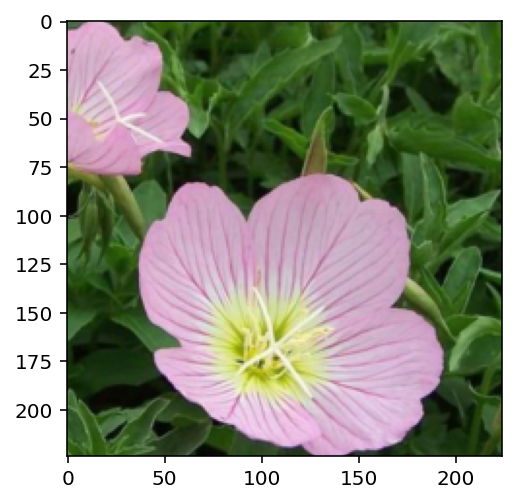

In [25]:
imshow(process_image('flowers/train/1/image_06738.jpg'))

In [26]:
def predict(path,model):
    img = process_image(path)
    img = img.float().unsqueeze_(0)
    img = img.to(device)
    with torch.no_grad():
        output = model.forward(img)
    ps = torch.exp(output)
    probs, indices = ps.topk(5)
    probs = probs.cpu().numpy()[0]
    indices = indices.cpu().numpy()[0]
    class_to_idx = {v:k for k,v in model.class_to_idx.items()}
    classes = [class_to_idx[x] for x in indices]
    return probs, classes

In [27]:
predict('flowers/train/1/image_06738.jpg',model)

(array([0.6358325 , 0.07929627, 0.07359057, 0.06597604, 0.03631742],
       dtype=float32),
 ['1', '19', '76', '51', '93'])

<AxesSubplot:>

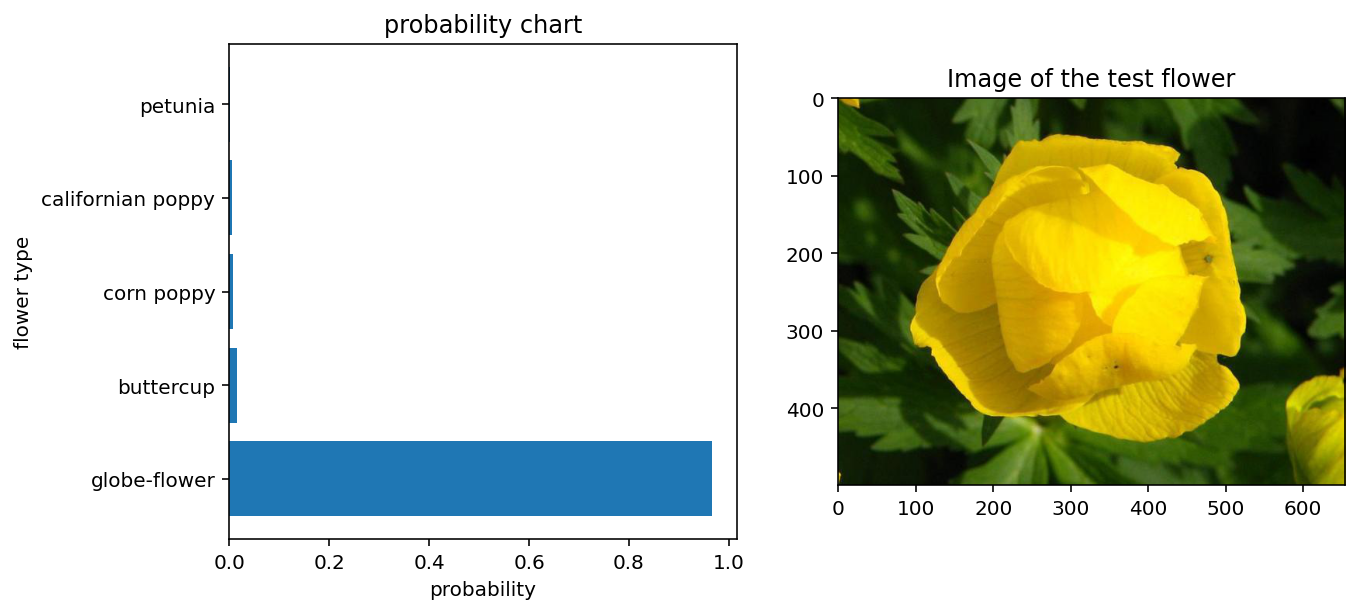

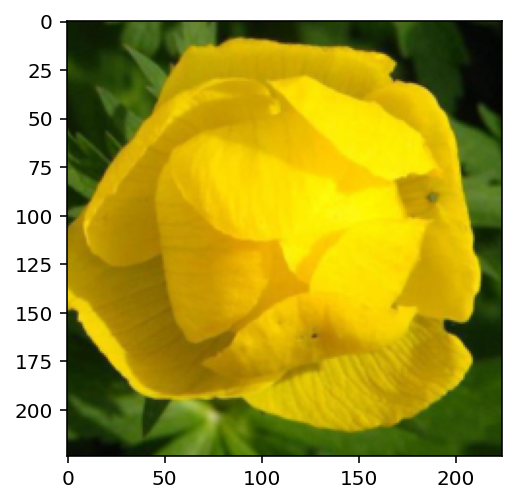

In [28]:
path = 'flowers/train/16/image_06685.jpg'
probs, classes = predict(path,model)

flower_names = [cat_to_name[str(i)] for i in classes]

#sub1
plt.figure(figsize = (10,10))
ax1 = plt.subplot(222)
img = Image.open(path)
ax1.set_title('Image of the test flower')
ax1.imshow(img)

#sub2 
ax2 = plt.subplot(221)
yticks = np.arange(5)
ax2.set_yticks(yticks)
ax2.set_yticklabels(flower_names)
ax2.set_title('probability chart')
ax2.set_xlabel('probability')
ax2.set_ylabel('flower type')

ax2.barh(yticks, probs, align = 'center')

image = process_image((path))
imshow(image)